# Sales

The goal of this project is to analyze historical sales data and develop a forecasting model to predict future sales trends. This involves data preprocessing, exploratory analysis, and the application of time series models such as Holt-Winters, Arima and Sarimax. The results will help identify patters in sales behavior and improve decision-making for business planning. 


## Librerías
- Import from several libraries for data analysis and time seriers modelling are imported, including `nunmpy`, `pandas`, `matplotlib`, `statsmodels`, `pmdarima` and `skforecast`.


In [1]:
# Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
# pmdarima
#%pip install pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# skforecast
#%pip install skforecast
from skforecast.sarimax import Sarimax
#from skforecast.ForecasterSarimax  import ForecasterSarimax
#from skforecast.model_selection_sarimax import backtesting_sarimax
#from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import warnings

# Dataset Import
- A CSV file named `sales.csv` from Kaggel. Url: https://www.kaggle.com/datasets/sudipmanchare/simulated-sales-data-with-timeseries-features/data
- CSV file is imported into a DataFrame.

In [2]:
train = pd.read_csv("sales.csv")
print(train.head())
if (train.isna().sum().sum() > 0):
	print(train.isna().sum())
train.info()


   Unnamed: 0        Date      Sales
0           0  2021-10-01  29.109547
1           1  2021-10-02  30.720435
2           2  2021-10-03  30.305173
3           3  2021-10-04  27.390893
4           4  2021-10-05  22.841123
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  365 non-null    int64  
 1   Date        365 non-null    object 
 2   Sales       365 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ KB


## Dataset Preprocessing
- Check if Dataset has any NULL or NaN values
- Check the Datatypes from each column
- The `Unnamed: 0` column is dropped, because it's unneeded for a time series analysis.
- The `Date` column is converted to datetime format and set as the DataFrame index.

In [3]:
train = train.drop(["Unnamed: 0"], axis = 1)
train["Date"] = pd.to_datetime(train["Date"])
train.set_index("Date", inplace = True)
train.head()

,Sales
Date,
2021-10-01,29.109547
2021-10-02,30.720435
2021-10-03,30.305173
2021-10-04,27.390893
2021-10-05,22.841123


## Train and Test Split
- The last 20 records are separated as the test set `test`.
- The remaining data is reassigned as the training set `train`.

In [4]:
test = train.tail(20)
train = train.iloc[: -20]
print(train, test)

                Sales
Date                 
2021-10-01  29.109547
2021-10-02  30.720435
2021-10-03  30.305173
2021-10-04  27.390893
2021-10-05  22.841123
...               ...
2022-09-06  38.842074
2022-09-07  36.326336
2022-09-08  39.066668
2022-09-09  43.281417
2022-09-10  47.029356

[345 rows x 1 columns]                 Sales
Date                 
2022-09-11  46.196079
2022-09-12  41.935306
2022-09-13  38.280269
2022-09-14  37.708243
2022-09-15  40.454160
2022-09-16  44.081351
2022-09-17  46.382487
2022-09-18  48.190967
2022-09-19  41.960551
2022-09-20  37.821271
2022-09-21  36.958533
2022-09-22  38.611436
2022-09-23  44.717520
2022-09-24  47.690622
2022-09-25  47.796793
2022-09-26  43.698457
2022-09-27  38.827336
2022-09-28  38.761570
2022-09-29  41.144471
2022-09-30  45.529812


## SEASONALITY ANALYSIS
- Graphic overview from `Train` and `Test` data
- There is clear upward trend overtime, however the variance is relatively stable, although there are some fluctuations. 
- The series is heteroelasti, as the variability changes over time
- The series is not stationary, sincde both the mean and the variability show changes over time.
- The series seems to have seasonality, since it exhibits a recurrent pattern every week

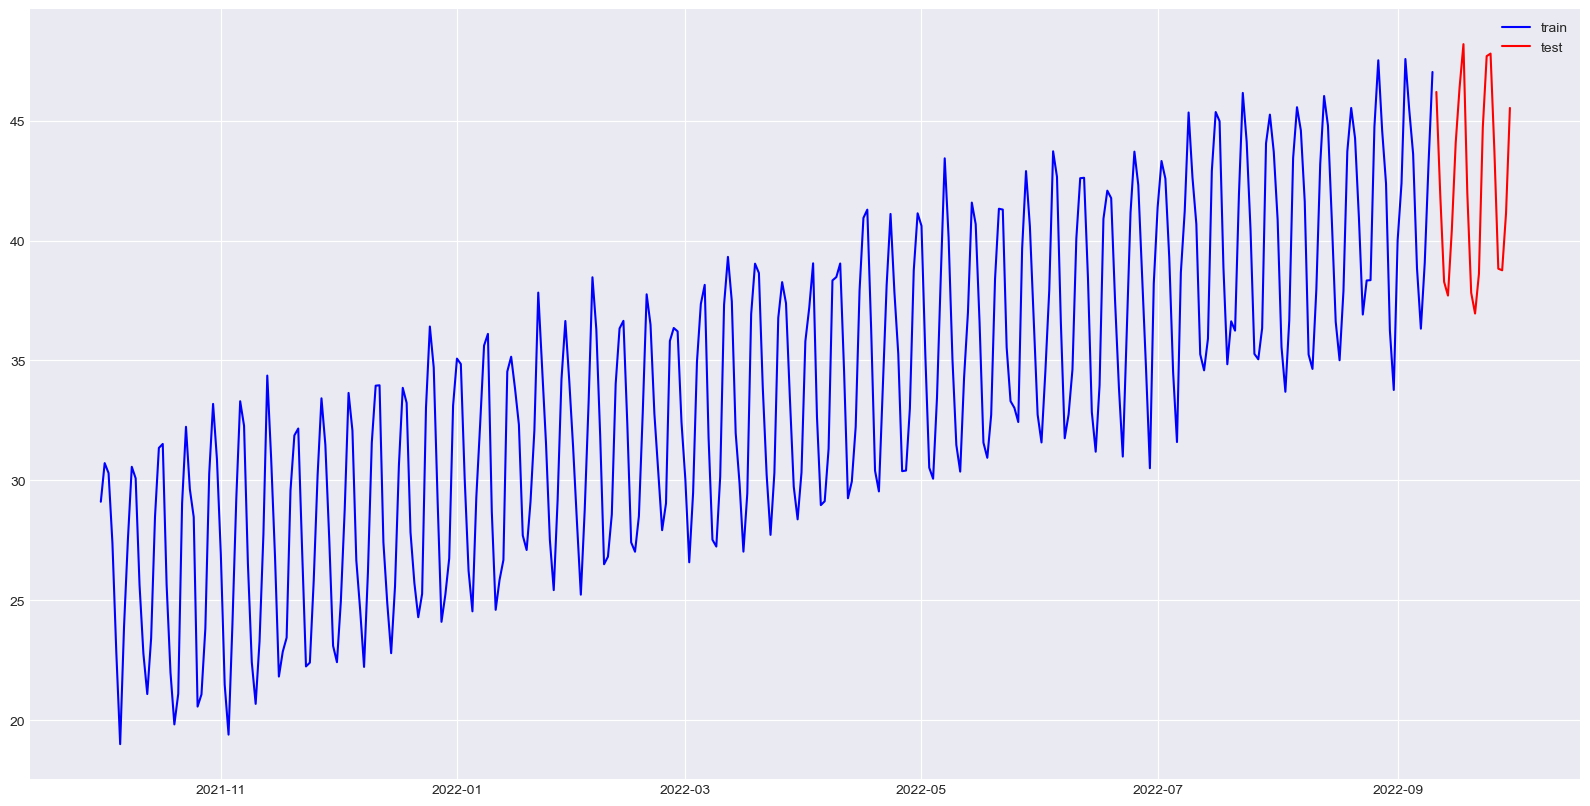

In [5]:
plt.figure(figsize = (20, 10))
plt.plot(train, color = "blue", label = "train")
plt.plot(test, color = "red", label = "test")
plt.legend()
plt.show()

### Sesonal Decomposition


In [6]:
# Se considera que la variabilidad es constante -> additive
result = seasonal_decompose(train["Sales"], model = "additive")

In [7]:
result.seasonal

Date
2021-10-01    2.603807
2021-10-02    5.540448
2021-10-03    4.368757
2021-10-04    0.039774
2021-10-05   -4.297173
                ...   
2022-09-06   -4.297173
2022-09-07   -5.473694
2022-09-08   -2.781920
2022-09-09    2.603807
2022-09-10    5.540448
Name: seasonal, Length: 345, dtype: float64

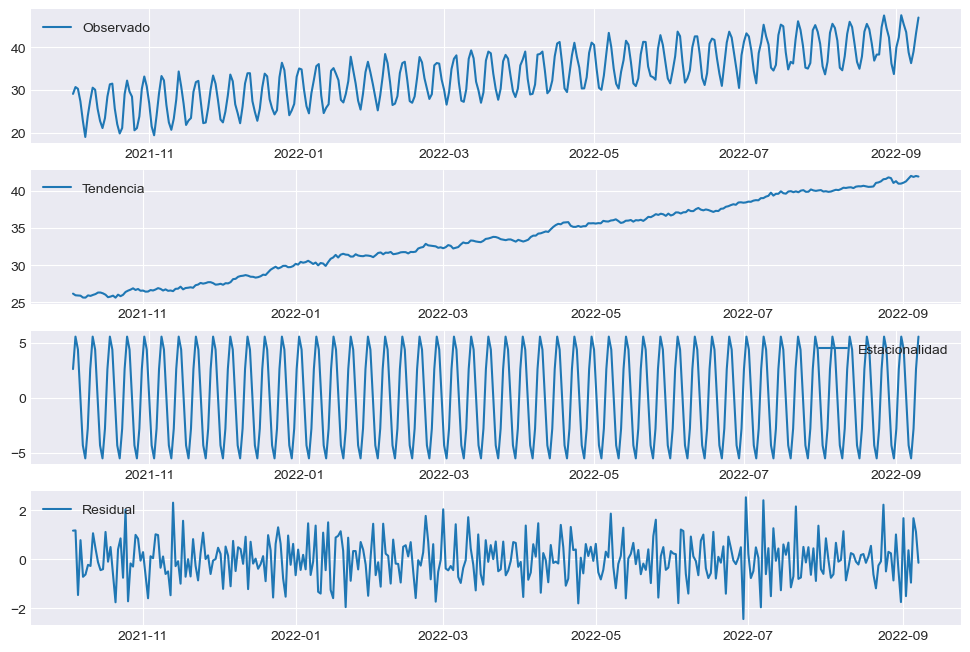

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed, label="Observado")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label="Tendencia")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label="Estacionalidad")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label="Residual")
plt.legend()

plt.show()


As discussed above:
- Clear periodical pattern.
- Upward Trend
- Strong Seasonality
- Residual: representes unexplained fluctuations after removing trend and seasonality. Variability exists without a clear pattern, suggesting the decompositiion captured key components. Peaks may indicate outliers

## Smoothness Model

In [9]:
train_TR = train
print(train_TR)

                Sales
Date                 
2021-10-01  29.109547
2021-10-02  30.720435
2021-10-03  30.305173
2021-10-04  27.390893
2021-10-05  22.841123
...               ...
2022-09-06  38.842074
2022-09-07  36.326336
2022-09-08  39.066668
2022-09-09  43.281417
2022-09-10  47.029356

[345 rows x 1 columns]


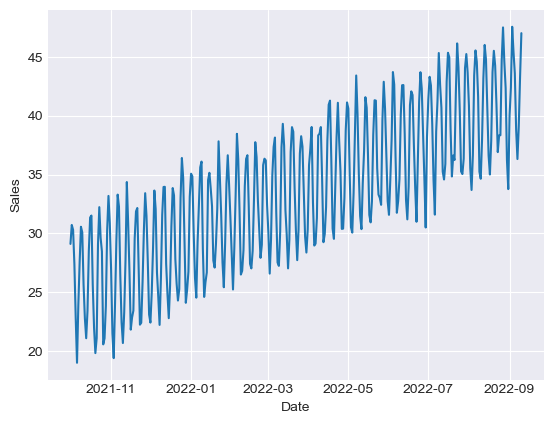

In [10]:
sns.lineplot(train_TR["Sales"])
plt.show()

### HOLT-WINTERS
- Uses exponential smooting to encode values from the past and use them to predict "typical" values for the present and future.

**The chosen parameters were**:
- `trend = "add"`: trend component is modeled additively, meaning the series grows over time by adding a constant value at each period, resulting in a linear trend rather than a parabolic one.
- `seasonal="additive"`: The seasonality is modeled additively, chosen because the seasonal amplitude remains approximately constant over time.
- `seasonal_periods=7`: Indicates that seasonal patterns repeat roughly every 7 days, suggesting a weekly seasonality.

For forecasting, a step of 20 was selected, representing 20 days, which corresponds to the reserved test dataset.

In [11]:
import statsmodels.api as sm

modelo_holt_winters = sm.tsa.ExponentialSmoothing(train_TR["Sales"], trend = "add",
												  seasonal = "additive", seasonal_periods = 7).fit()
predicciones_hw = modelo_holt_winters.forecast(steps = 20)
modelo_holt_winters.summary()

c:\Users\Josed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Dep. Variable:,Sales,No. Observations:,345
Model:,ExponentialSmoothing,SSE,322.027
Optimized:,True,AIC,-1.774
Trend:,Additive,BIC,40.505
Seasonal:,Additive,AICC,-0.674
Seasonal Periods:,7,Date:,"Sat, 22 Mar 2025"
Box-Cox:,False,Time:,11:28:18
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.8207e-08,alpha,True
smoothing_trend,9.1208e-11,beta,True


In [12]:
test

,Sales
Date,
2022-09-11,46.196079
2022-09-12,41.935306
2022-09-13,38.280269
2022-09-14,37.708243
2022-09-15,40.454160
2022-09-16,44.081351
2022-09-17,46.382487
2022-09-18,48.190967
2022-09-19,41.960551


In [13]:
predicciones_hw

2022-09-11    46.451919
2022-09-12    42.172267
2022-09-13    37.876905
2022-09-14    36.747628
2022-09-15    39.481526
2022-09-16    44.918343
2022-09-17    47.890204
2022-09-18    46.795050
2022-09-19    42.515399
2022-09-20    38.220036
2022-09-21    37.090759
2022-09-22    39.824658
2022-09-23    45.261475
2022-09-24    48.233335
2022-09-25    47.138181
2022-09-26    42.858530
2022-09-27    38.563168
2022-09-28    37.433890
2022-09-29    40.167789
2022-09-30    45.604606
Freq: D, dtype: float64

In [14]:
modelo_holt_winters.params

{'smoothing_level': 1.8207252920954518e-08,
 'smoothing_trend': 9.120810015367641e-11,
 'smoothing_seasonal': 2.4920145991920528e-09,
 'damping_trend': nan,
 'initial_level': 25.21516214916025,
 'initial_trend': 0.04901874676148055,
 'initial_seasons': array([ 2.49760122,  5.42044325,  4.27627011, -0.05239982, -4.39678083,
        -5.57507703, -2.89019721]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

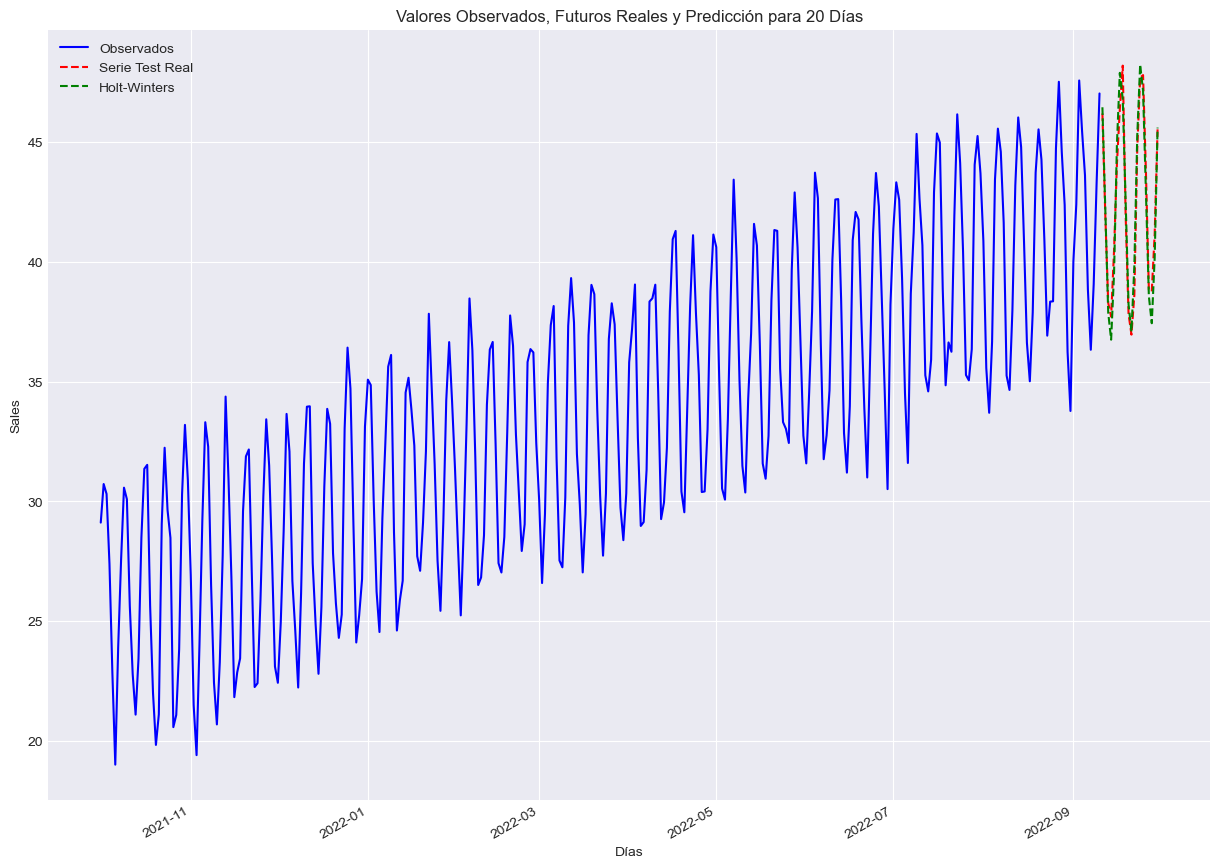

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(train_TR.index, train_TR['Sales'], label = 'Observados', linestyle='-', color='blue')
plt.plot(test.index, test['Sales'], label = 'Serie Test Real', linestyle='--', color='red')
plt.plot(predicciones_hw.index, predicciones_hw, label = 'Holt-Winters', linestyle='--',color='green')

plt.xlabel('Días')
plt.ylabel('Sales')
plt.title('Valores Observados, Futuros Reales y Predicción para 20 Días')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

- The Holt-Winters model demonstrates strong performance when evaluated against the test data.

#### Error Analysis and Model Evaluation
This section calculates the absolute errors between the actual sales `test['Sales']` and the predicted values `predicciones_hw` from the Holt-Winters model. The Mean Absolute Error (MAE) is then computed to quantify the model’s average prediction error.

In [16]:
errores = abs(test['Sales']-predicciones_hw)
print(errores.head())

Date
2022-09-11    0.255839
2022-09-12    0.236961
2022-09-13    0.403364
2022-09-14    0.960616
2022-09-15    0.972634
dtype: float64


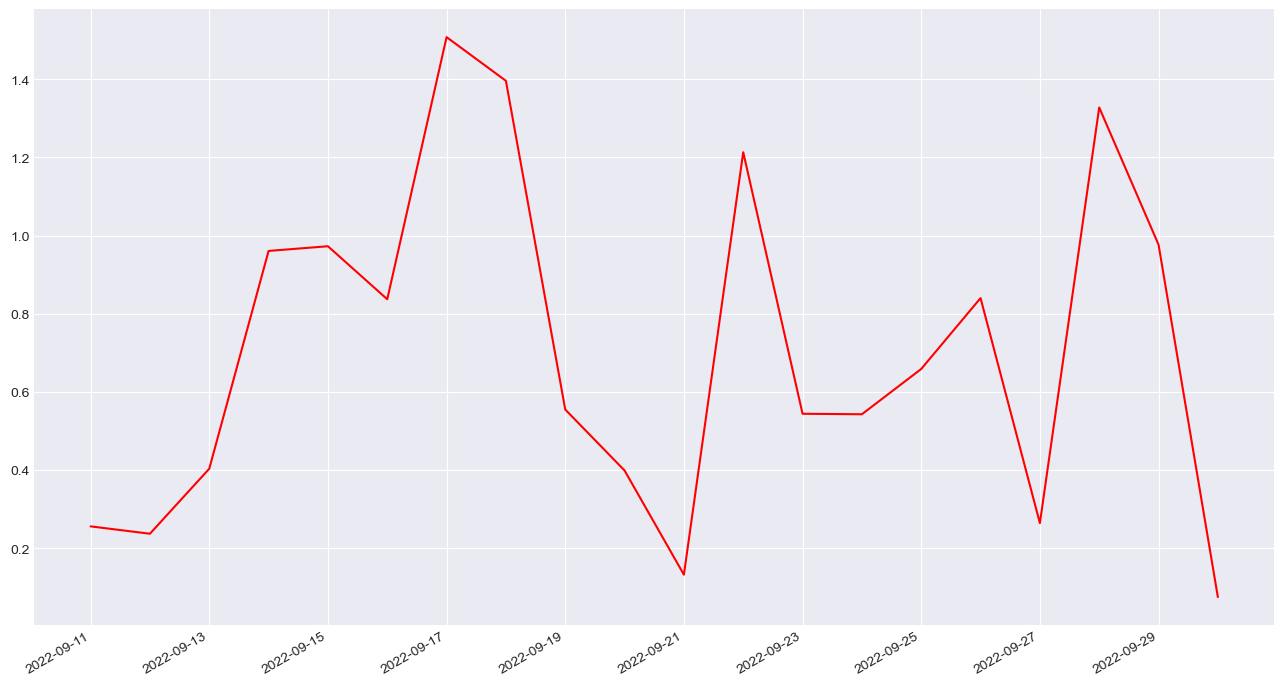

In [17]:
# esto nos permite conocer en qué meses se cometieron más errores
plt.figure(figsize = (16, 8))
plt.plot(errores, label='errores', linestyle='-', color='red')
plt.xticks(rotation=30, ha='right')
plt.show()

In [18]:
mae = np.mean(errores)
print(mae)

0.7048815943863573


The model gets a mae value of 0.705, which seems like a good perfomance. It will be compared to other models later.

### HOLT-WINTERS-LOG

After doing standard Holt-Winters a logarithmic transformation and differencing was done to stabilize variance and remove trends, making the series more stationary. This improves the effectiveness of the **Holt-Winters** model in capturing underlying patterns.

Parameters were the same as before.

In [19]:
train_log = np.log(train_TR['Sales'])
train_log_diff = train_log.diff().dropna()
modelo_hw_diff = sm.tsa.ExponentialSmoothing(train_log_diff, trend='add', seasonal='add', seasonal_periods=7).fit()
pred_diff = modelo_hw_diff.forecast(steps=20)

c:\Users\Josed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [20]:
last_log_value = train_log.iloc[-1]  
pred_log = last_log_value + pred_diff.cumsum()
pred_final = np.exp(pred_log)
print(pred_final)

2022-09-11    45.534902
2022-09-12    41.665467
2022-09-13    36.629035
2022-09-14    35.377957
2022-09-15    38.522812
2022-09-16    44.122966
2022-09-17    47.281646
2022-09-18    45.779348
2022-09-19    41.889300
2022-09-20    36.825951
2022-09-21    35.568282
2022-09-22    38.730202
2022-09-23    44.360673
2022-09-24    47.536550
2022-09-25    46.026329
2022-09-26    42.115453
2022-09-27    37.024908
2022-09-28    35.760581
2022-09-29    38.939743
2022-09-30    44.600845
Freq: D, dtype: float64


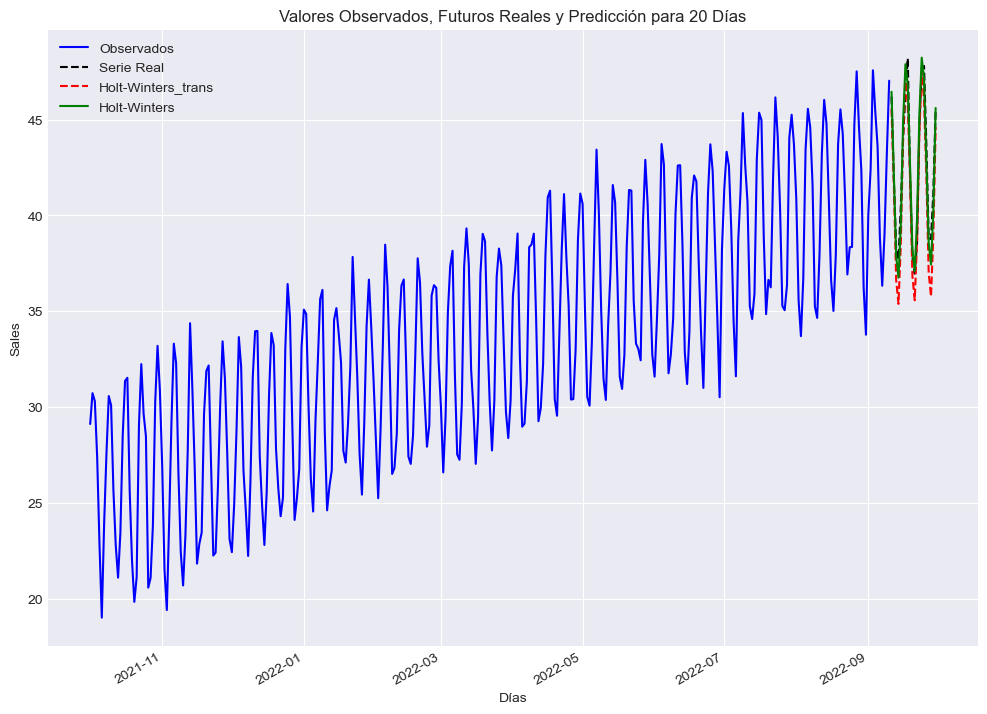

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(train_TR.index, train_TR['Sales'], label='Observados', linestyle='-', color='blue')
plt.plot(test.index, test['Sales'], label='Serie Real', linestyle='--', color='black')
plt.plot(pred_final.index, pred_final, label='Holt-Winters_trans', linestyle='--',color='red')
plt.plot(predicciones_hw.index, predicciones_hw, label='Holt-Winters', linestyle='-',color='green')
predicciones_hw
plt.xlabel('Días')
plt.ylabel('Sales')
plt.title('Valores Observados, Futuros Reales y Predicción para 20 Días')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

- The **Holt-Winters_Trans** model exhibits strong performance when assessed against the test data.

#### Error Analysis and Model Evaluation

In [22]:
errores = abs(test['Sales']-pred_final)
mae = np.mean(errores)
print(mae)

1.228668303448168


The model gets a mae value of 1.22, which seems like a good perfomance, but it's clearly worse than the standard Holt-Winters.

<!-- ## Autocorrelation -->

## Autocorrelation

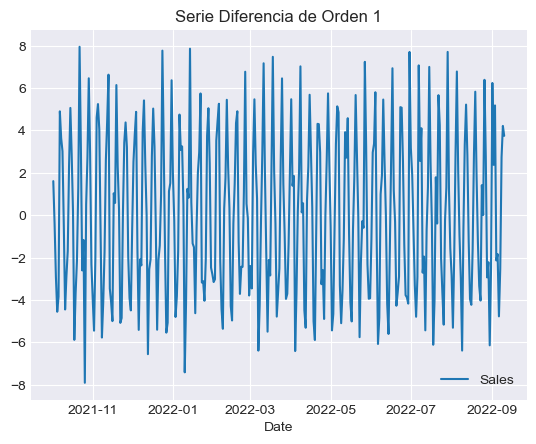

In [23]:
sns.lineplot(train.diff())
plt.title("Serie Diferencia de Orden 1")
plt.show()

To check whether the serie is stationary or not, the `ADF` and `KPSS` are calculated.

In [24]:
datos_diff_1 = train.diff(1).dropna()
print('Test estacionariedad serie original')
print(f'ADF Statistic: {adfuller(train)[0]}, p-value: {adfuller(train)[1]}')
print(f'KPSS Statistic: {kpss(train)[0]}, p-value: {kpss(train)[1]}')
print('\nTest estacionariedad serie diferenciada de orden 1')
print(f'ADF Statistic: {adfuller(datos_diff_1)[0]}, p-value: {adfuller(datos_diff_1)[1]}')
print(f'KPSS Statistic: {kpss(datos_diff_1)[0]}, p-value: {kpss(datos_diff_1)[1]}')

Test estacionariedad serie original
ADF Statistic: 0.07812950077951043, p-value: 0.9645357791440596
KPSS Statistic: 3.397841564335598, p-value: 0.01

Test estacionariedad serie diferenciada de orden 1
ADF Statistic: -6.545648615851154, p-value: 9.113772010817752e-09
KPSS Statistic: 0.46634643441349827, p-value: 0.04924629855551842


C:\Users\Josed\AppData\Local\Temp\ipykernel_15540\2972287105.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(f'KPSS Statistic: {kpss(train)[0]}, p-value: {kpss(train)[1]}')
C:\Users\Josed\AppData\Local\Temp\ipykernel_15540\2972287105.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(f'KPSS Statistic: {kpss(train)[0]}, p-value: {kpss(train)[1]}')


**Original series:**
ADF Statistic = 0.0781, p-value = 0.9645. Iindicates that the series is not stationary.
KPSS Statistic = 3.3978, p-value = 0.01. Indicates that the series is not stationary.

**1. Differenced Series:**
ADF Statistic = -6.5456, p-value = 9.11e-09. Indicates that the series is now stationary.
KPSS Statistic = 0.4663, p-value = 0.0492. Indicates that the series is stationary.

To determina the values for the ARIMA model, we use a plot with `50 lags` and `alpha= 0.05`. 

The analysis shows a sharp drop after the first lags, characteristic of an AR(p) process. The ACF suggests a slow decline, indicating a potential MA(q) or ARMA model, while the PACF points to a low-order AR component in an ARIMA model.

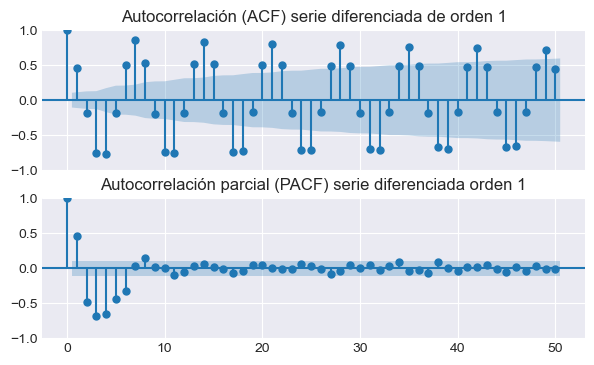

In [25]:
# Autocorrelation plot for the differenced series.
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(datos_diff_1, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación (ACF) serie diferenciada de orden 1')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación parcial (PACF) serie diferenciada orden 1')
plt.show()


In [26]:

# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq')

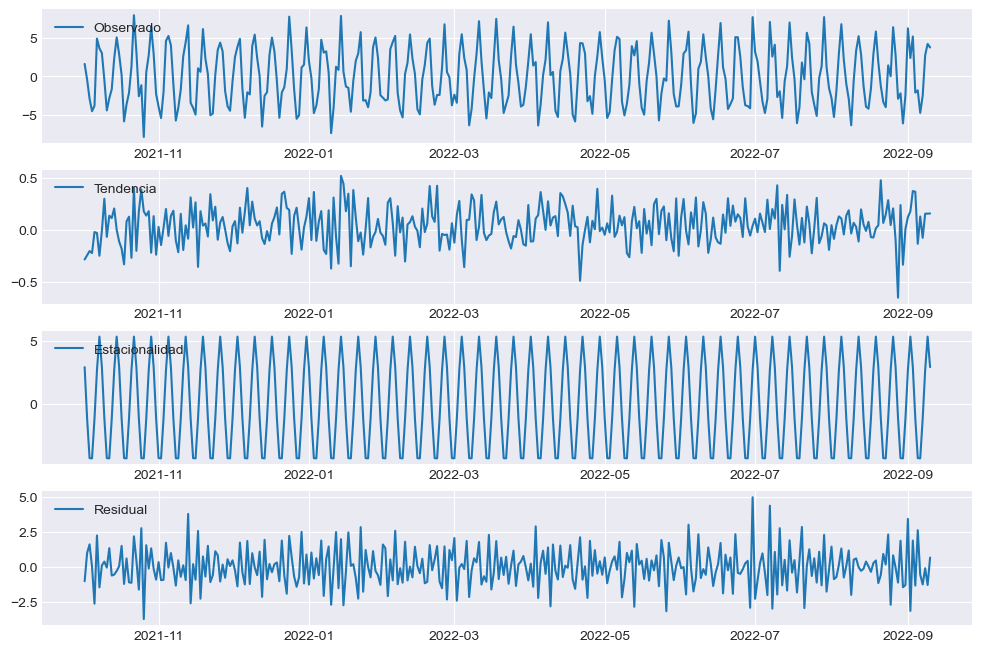

In [27]:
# Visualizar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(res_decompose.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(res_decompose.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(res_decompose.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(res_decompose.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

The differenced series still exhibits high seasonality, so an attempt was made to remove it by differencing with a lag of 7.

In [28]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_7 = datos_diff_1.diff(7).dropna()
print('Test estacionariedad serie de orden 7')
print('\nTest estacionariedad serie diferenciada de orden 7')
print(f'ADF Statistic: {adfuller(datos_diff_1_7)[0]}, p-value: {adfuller(datos_diff_1_7)[1]}')
print(f'KPSS Statistic: {kpss(datos_diff_1_7)[0]}, p-value: {kpss(datos_diff_1_7)[1]}')

Test estacionariedad serie de orden 7

Test estacionariedad serie diferenciada de orden 7
ADF Statistic: -9.58159604621037, p-value: 2.1511532423012928e-16
KPSS Statistic: 0.09138752664055161, p-value: 0.1


C:\Users\Josed\AppData\Local\Temp\ipykernel_15540\1570232851.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f'KPSS Statistic: {kpss(datos_diff_1_7)[0]}, p-value: {kpss(datos_diff_1_7)[1]}')
C:\Users\Josed\AppData\Local\Temp\ipykernel_15540\1570232851.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f'KPSS Statistic: {kpss(datos_diff_1_7)[0]}, p-value: {kpss(datos_diff_1_7)[1]}')


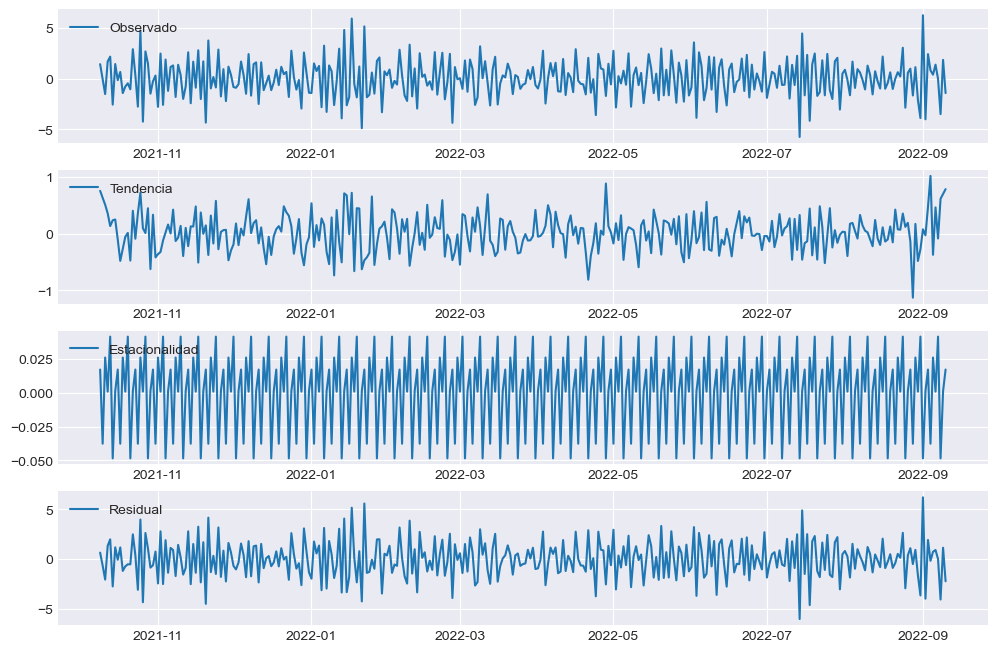

In [29]:
res_decompose = seasonal_decompose(datos_diff_1_7, model='additive', extrapolate_trend='freq')
# Visualizar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(res_decompose.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(res_decompose.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(res_decompose.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(res_decompose.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

After differencing by 7, seasonality still appears but it has been reduce. However, it's not enough and therefore, `D = 1` will be used for the Arima model.

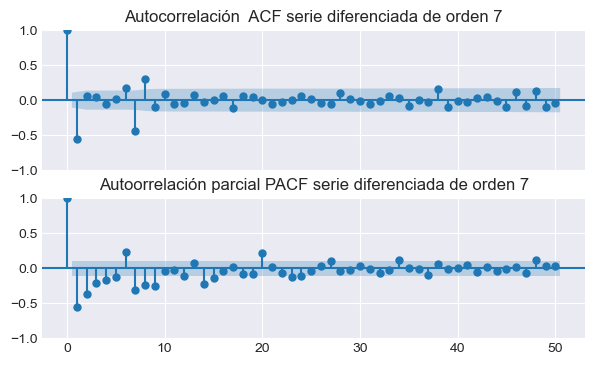

In [30]:

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(datos_diff_1_7, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación  ACF serie diferenciada de orden 7')
plot_pacf(datos_diff_1_7, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial PACF serie diferenciada de orden 7')
plt.show()


- The series is stationary after applying a differentiation of order 7, so that d = 1 and D = 1 are set to eliminate trend and weekly seasonality.

- The PACF shows a significant cut-off at lag 1, suggesting	 a self-regressive order of p = 1.
A peak is also observed at lag 7, which justifies the choice of P = 1.

- The ACF decreases rapidly after the first lag and oscillates close to 0, suggesting q = 1. As in PACF, a peak is detected at lag 7, p so that we set Q = 1.

## MODEL SARIMAX MANUALLY SELECTED PARAMETERS

The values are applied to the model.

In [31]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 7))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

c:\Users\Josed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Josed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  345
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -484.731
Date:                           Sat, 22 Mar 2025   AIC                            979.463
Time:                                   11:28:22   BIC                            998.563
Sample:                               10-01-2021   HQIC                           987.076
                                    - 09-10-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1192      0.056     -2.121      0.034      -0.229      -0.009
ma.L1         -0.9317      0.024    -38.321      0.000      -0.979      -0.884
ar.S.L7        0.0890      0.064      1.386      0.166      -0.037       0.215
ma.S.L7       -0.9997      6.366     -0.157      0.875     -13.476      11.477
sigma2         0.9512      6.031      0.158      0.875     -10.869      12.772
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.94   Prob(JB):                         0.45
Heteroskedasticity (H):               0.92   Skew:                             0.14
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
from statsmodels.stats.diagnostic import acorr_ljungbox
estadistico_lb, p_valor_lb = acorr_ljungbox(modelo_res.resid, lags=[7, 14, 50])

In [33]:
# Predicción
# ==============================================================================
predicciones = modelo_res.get_forecast(steps=20)
predicciones_statsmodels = predicciones.predicted_mean
intervalo_conf = predicciones.conf_int(alpha=0.05)
print(f"Intervalo Confianza = {intervalo_conf.head()}")
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

Intervalo Confianza =             lower Sales  upper Sales
2022-09-11    44.433943    48.295664
2022-09-12    40.312918    44.179522
2022-09-13    35.976196    39.853450
2022-09-14    34.712487    38.596521
2022-09-15    37.444558    41.335707


2022-09-11    46.364803
2022-09-12    42.246220
2022-09-13    37.914823
2022-09-14    36.654504
Freq: D, Name: predicciones_statsmodels, dtype: float64

In [34]:
# se comprueba lo predicho con los valores reales
print(test)

                Sales
Date                 
2022-09-11  46.196079
2022-09-12  41.935306
2022-09-13  38.280269
2022-09-14  37.708243
2022-09-15  40.454160
2022-09-16  44.081351
2022-09-17  46.382487
2022-09-18  48.190967
2022-09-19  41.960551
2022-09-20  37.821271
2022-09-21  36.958533
2022-09-22  38.611436
2022-09-23  44.717520
2022-09-24  47.690622
2022-09-25  47.796793
2022-09-26  43.698457
2022-09-27  38.827336
2022-09-28  38.761570
2022-09-29  41.144471
2022-09-30  45.529812


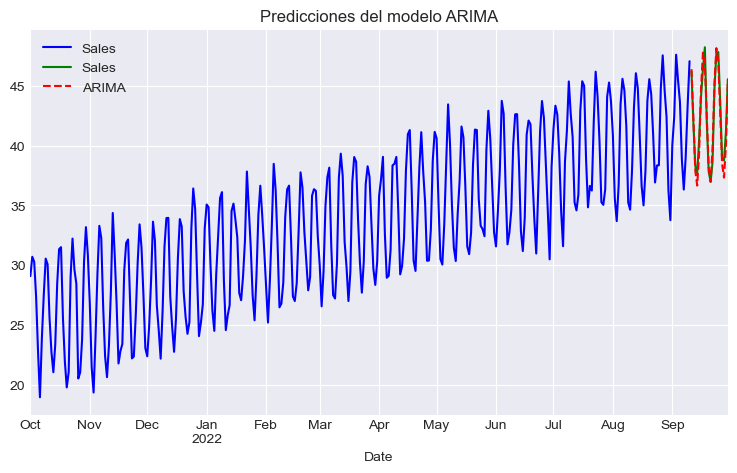

In [35]:
# Plot predictions
fig, ax = plt.subplots(figsize=(9, 5))
train.plot(ax=ax, label='Observados', color = "blue")
test.plot(ax=ax, label='Reales',  color = "green")
predicciones_statsmodels.plot(ax=ax, label='ARIMA',linestyle='--', color = "red")
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

#### Error Analysis and Model Evaluation

In [36]:
test = test["Sales"]

In [37]:
# Mean Squared Error (MSE)
mse = mean_squared_error(test, predicciones_statsmodels)
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(test, predicciones_statsmodels)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 0.6904600132812322
Root Mean Squared Error (RMSE): 0.8309392356130695
Mean Absolute Error (MAE): 0.6946959263284562


These values are considered great because they reflect very low prediction errors, and their interpretation is easier when considering their square and root transformations:

- MSE (Mean Squared Error) and MAE (Mean Absolute Error): Both are 0.69, indicating a very small error relative to the prediction. Since MSE involves squaring the errors, it amplifies larger discrepancies, but in this case, it still results in a value close to the MAE, showing consistent accuracy across predictions.

- RMSE (Root Mean Squared Error): With a value of 0.83, RMSE gives an error magnitude in the same units as the original data, making it easier to interpret. Since RMSE involves taking the square root of the squared errors, it tends to give a more conservative measure of error compared to MSE. The fact that the RMSE is low (around 1.8%) suggests the model’s predictions are highly accurate and the overall error is quite minimal.

In essence, the low values across all these metrics demonstrate that the model’s predictions are very close to the actual values, with errors around 1.5-1.8%, which is excellent for most forecasting tasks.

## SARIMAX MODEL AUTOMATICALLY SELECTED PARAMETERS

The previous model used input parameters selected through analysis of the graph and data. Now, we will use auto_arima to automatically determine the most optimal parameters for the model.

In [38]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
modelo = auto_arima(
            y                 = train,
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 7, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\J

 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=1178.303, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2260.961, Time=0.01 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.55 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=1749.659, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=3418.601, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=1933.466, Time=0.14 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.38 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.14 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=1191.420, Time=1.29 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=1695.295, Time=0.37 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=inf, Time=1.23 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.37 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=1161.598, Time=0.66 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=1651.083, Time=0.24 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=1177.555, Time=1.58 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=1160.929, Time=1.42 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=1526.665, Time=0.47 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.62 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,2)[7] intercept   : AIC=1150.275, Time=1.60 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,2)[7] intercept   : AIC=1525.449, Time=0.59 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=1153.687, Time=1.00 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.77 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=1606.496, Time=0.33 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.42 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,2)[7] intercept   : AIC=1131.364, Time=1.69 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,2)[7] intercept   : AIC=1523.398, Time=0.95 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[7] intercept   : AIC=1136.168, Time=1.18 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.24 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[7] intercept   : AIC=1608.244, Time=0.41 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.97 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=1.93 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[7] intercept   : AIC=1164.365, Time=1.64 sec


c:\Users\Josed\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,2)[7]             : AIC=inf, Time=1.55 sec

Best model:  ARIMA(3,0,0)(1,0,2)[7] intercept
Total fit time: 33.572 seconds


The optimal ARIMA values are: **ARIMA(3,0,0)(1,0,2)[7]**

In [39]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo_final = SARIMAX(endog = train, order = (3,0,0), seasonal_order = (1, 0, 2, 7))
modelo_final_res = modelo_final.fit(disp=0)
warnings.filterwarnings("default")
modelo_final_res.summary()

c:\Users\Josed\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  Sales   No. Observations:                  345
Model:             SARIMAX(3, 0, 0)x(1, 0, [1, 2], 7)   Log Likelihood                -547.301
Date:                                Sat, 22 Mar 2025   AIC                           1108.601
Time:                                        11:28:57   BIC                           1135.506
Sample:                                    10-01-2021   HQIC                          1119.316
                                         - 09-10-2022                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2434      0.048      5.093      0.000       0.150       0.337
ar.L2          0.3919      0.050      7.842      0.000       0.294       0.490
ar.L3          0.3625      0.049      7.452      0.000       0.267       0.458
ar.S.L7        1.0000   2.88e-05   3.47e+04      0.000       1.000       1.000
ma.S.L7       -0.8991      0.036    -25.261      0.000      -0.969      -0.829
ma.S.L14      -0.0758      0.015     -5.056      0.000      -0.105      -0.046
sigma2         1.2080      0.098     12.347      0.000       1.016       1.400
===================================================================================
Ljung-Box (L1) (Q):                   2.00   Jarque-Bera (JB):                 1.22
Prob(Q):                              0.16   Prob(JB):                         0.54
Heteroskedasticity (H):               0.94   Skew:                             0.07
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
predicciones = modelo_final_res.get_forecast(steps=20)
predicciones_statsmodels_fin = predicciones.predicted_mean
intervalo_conf = predicciones.conf_int(alpha=0.05)
print(f"Intervalo Confianza = {intervalo_conf.head()}")
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

Intervalo Confianza =             lower Sales  upper Sales
2022-09-11    43.504901    47.823005
2022-09-12    39.278594    43.722086
2022-09-13    34.838030    39.688596
2022-09-14    33.230525    38.663489
2022-09-15    35.810012    41.513362


2022-09-11    46.364803
2022-09-12    42.246220
2022-09-13    37.914823
2022-09-14    36.654504
Freq: D, Name: predicciones_statsmodels, dtype: float64

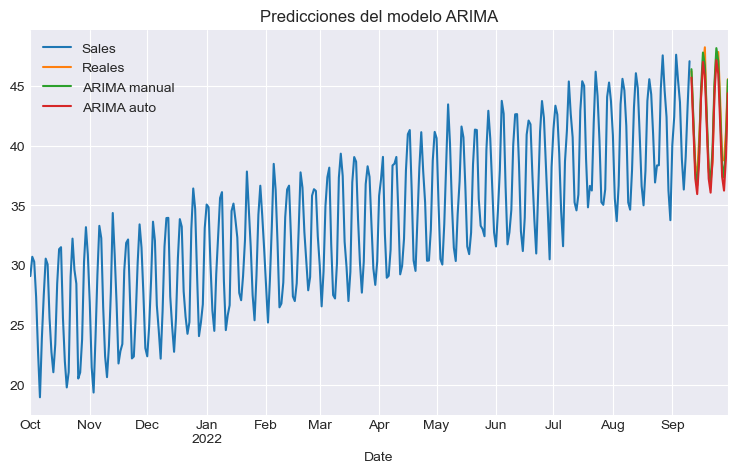

In [41]:
# Plot predictions
fig, ax = plt.subplots(figsize=(9, 5))
train.plot(ax=ax, label='Serie')
test.plot(ax=ax, label='Reales')
predicciones_statsmodels.plot(ax=ax, label='ARIMA manual')
predicciones_statsmodels_fin.plot(ax=ax, label='ARIMA auto')
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

Both curves are displayed.

#### Error Analysis and Model Evaluation

In [42]:
# Mean Squared Error (MSE)
mse = mean_squared_error(test, predicciones_statsmodels_fin)
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(test, predicciones_statsmodels_fin)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 1.8714711979392848
Root Mean Squared Error (RMSE): 1.3680172506000372
Mean Absolute Error (MAE): 1.1413157687996514


These values indicate low prediction errors:

- **MSE (1.87)**: The squared error is relatively low, showing the model doesn’t have large discrepancies.
- **RMSE (1.37)**: In the same units as the original data, RMSE confirms minimal error, providing a more conservative estimate.
- **MAE (1.14)**: The mean absolute error is also low, indicating overall good accuracy in predictions.

These results suggest that the model performs well, with errors remaining small and indicating high predictive accuracy.

## CONCLUSION

Although all models perform well, the ARIMA manual model stands out as the best due to its superior performance and error analysis.

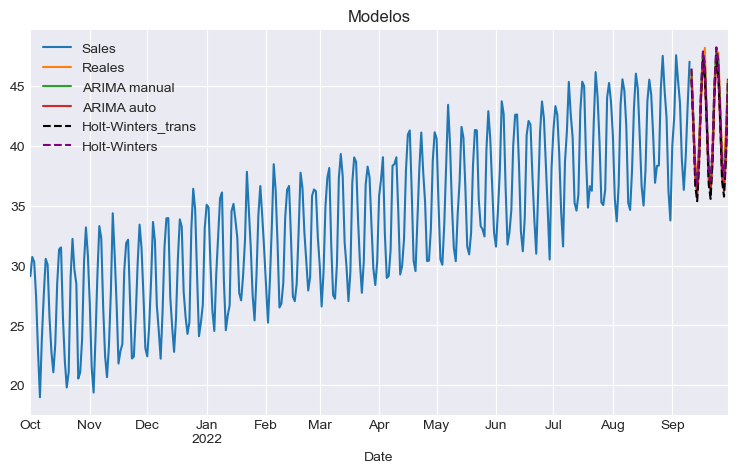

In [43]:
fig, ax = plt.subplots(figsize=(9, 5))
train.plot(ax=ax, label='Serie')
test.plot(ax=ax, label='Reales')
predicciones_statsmodels.plot(ax=ax, label='ARIMA manual')
predicciones_statsmodels_fin.plot(ax=ax, label='ARIMA auto')
plt.plot(pred_final.index, pred_final, label='Holt-Winters_trans', linestyle='--',color='black')
plt.plot(predicciones_hw.index, predicciones_hw, label='Holt-Winters', linestyle='--',color='purple')
ax.set_title('Modelos')
ax.legend();